### Gradient boosting tree Classification implement with pure python

To implement with GBDT for classification with pure python to understand how it works. The reason for **Gradient** is when try to get leaf output or loss function will use **gradient descent** to get best values.

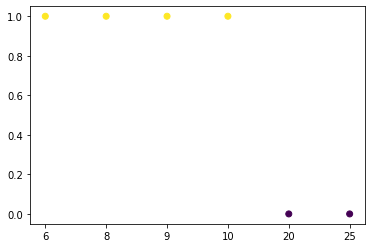

In [1]:
# sample data
import numpy as np
import matplotlib.pyplot as plt

data = np.array([[10, 25, 8, 20, 9, 6], ['a', 'a', 'b', 'a', 'b', 'a']]).T
label = np.array([1, 0, 1, 0, 1, 1])

# sort data based on first feature
sort_i = np.argsort(data[:, 0].astype(int))
data = data[sort_i]
label = label[sort_i]

plt.scatter(data[:, 0], label, c=label)
plt.show()

In [2]:
# wrap decsion tree build into a function, this is a regression tree!
def loss_function(truth, pred):
    return .5 * (truth - pred)**2

def classification_gain(residual, probs, la=0):
    return np.sum(residual) / (np.sum(probs * (1-probs)) + la)

def regression_gain(residual, la=0):
    return np.sum(residual)/(len(residual) + la)

# first make init guess with log(odds): odds=pos/neg
init_prob = np.log(sum(label)/ (len(label)-sum(label)))

# compure residual
first_residual = label - init_prob

# for classification also need first init pro
init_prob = np.array([init_prob  if x == 1 else (1-init_prob) for x in label])

# then should base on residual to build tree.
# should loop for each feature, and get lowest gain with that feature with index to split tree.
gain_list = []

# first feature is numeric, then should get medium value, second should just with count number.
num_data = sort= data[:, 0].astype(int)

# When try to get mid value should sort data first!
sorted_index = np.argsort(num_data)
num_data = num_data[sorted_index]

# residual and prob should be same index
residual = first_residual[sorted_index]
prob = init_prob[sorted_index]

first_num_mid_list = [(num_data[i] + num_data[i+1])/2 for i in range(len(num_data) - 1) ]

# loop for each split value
def _get_gain(residual, prob, sati):
    left_res = residual[sati]
    right_res = residual[np.logical_not(sati)]
    left_prob = prob[sati]
    right_prob = prob[np.logical_not(sati)]
    # should be weighted gain

    base_gain = classification_gain(residual, prob)

    left_gain = len(left_res) / len(residual) * classification_gain(left_res, left_prob)
    right_gain = len(right_res) / len(residual) * classification_gain(right_res, right_prob)

    final_gain = left_gain + right_gain - base_gain

    return final_gain

gain_list = []

num_gain_list = []
for mid in first_num_mid_list:
    left_sati = num_data <= mid
    
    final_gain = _get_gain(residual, prob, left_sati)
    num_gain_list.append(final_gain)


print("Num gain list: ", first_num_mid_list)
# Then should try to get best split value based on gain
best_split_num = first_num_mid_list[np.argmin(num_gain_list)]
gain_list.append((0, best_split_num, min(num_gain_list)))


# Then to process with non-numeric data
non_num = data[:, 1]

set_non_num = set(non_num)
non_num_gain_list = []
for non in set_non_num:
    left_sati = non == non_num
    
    final_gain = _get_gain(first_residual, init_prob, left_sati)
    non_num_gain_list.append(final_gain)
    
best_split_non = non_num[np.argmin(non_num_gain_list)]
gain_list.append((1, best_split_non, min(non_num_gain_list)))

print("Final gain value list: ", gain_list)

# get min value as the split value
sorted_gain_list = sorted(gain_list, key=lambda x: x[-1])

# choose split feature and value
split_feature = sorted_gain_list[0][0]
split_value = sorted_gain_list[0][1]

print("Choose feature: {} with value: {} as best split value".format(split_feature, split_value))

Num gain list:  [7.0, 8.5, 9.5, 15.0, 22.5]
Final gain value list:  [(0, 7.0, 0.0), (1, 'a', 2.7755575615628914e-17)]
Choose feature: 0 with value: 7.0 as best split value


In [3]:
# then we just need to build the tree.
class Tree:
    def __init__(self, data, residual, split_feature, split_value, prob=init_prob, feature_type='num', left_node=None, right_node=None, learning_rate=.3):
        # for tree output for each leaf is: sum(residaul)/(sum(prob*(1 - prob)))
        self.residual = residual
        self.split_feature = split_feature
        self.feature_type = feature_type
        self.split_value = split_value
        feature_data = data[:, split_feature]
        if feature_type == 'num':
            feature_data = feature_data.astype(int)
            left_sati = feature_data <= split_value
        else:
            left_sati = feature_data == split_value
        right_sati = np.logical_not(left_sati)    
        
        left_prob = prob[left_sati]
        right_prob = prob[right_sati]
        self.left_value = residual[left_sati]
        self.right_value = residual[right_sati]
        self.left_output = sum(self.left_value) / np.sum(left_prob * (1 - left_prob), axis=0)
        self.right_output = sum(self.right_value)/ np.sum(right_prob * (1 - right_prob), axis=0)
        
        self.left_data = data[left_sati]
        self.right_data = data[right_sati]
        
        # save left and right node, so that we could recurient to get from root
        self.left_node = left_node
        self.right_node = right_node
        self.learning_rate = learning_rate
        
    def __call__(self):
        print(self.residual)
        print("split feature: {} with split_value: {}".format(self.split_feature, self.split_value))
        print(self.left_value, self.right_value, sep='\t')
        print("leaf output")
        print(self.left_output, self.right_output, sep='\t')
        print("leaf data point")
        print(self.left_data, self.right_data, sep='\t')
       
    @staticmethod
    def _odds_to_prob(odds):
        return np.exp(odds)/ (1 + np.exp(odds))
    
        
    def predict(self, x_test, prob=init_prob):
        # predict = init_odds + learning_rate * output
        # how to make prediction, here is just one pass to select that feature and do comparation, and get the region of output data.
        feature_to_compare = x_test[:, self.split_feature]
        
        if self.feature_type == 'num':
            feature_to_compare = feature_to_compare.astype(int)
        
        out_odds = []
        for f in feature_to_compare:
            if self.feature_type == 'num':
                if f <= self.split_value:
                    out = self.left_output
                else:
                    out = self.right_output
            else:
                if f == self.split_value:
                    out = self.left_output
                else:
                    out = self.right_output
            # append out into list
            out_odds.append(out)
        out_odds = np.array(out_odds)
        print("Get output odds:", out_odds)
        # out should be: init_odds + learning_rate * output
        final_out_odds = prob +self.learning_rate * out_odds
        return   self._odds_to_prob(final_out_odds)
    
tree = Tree(data, residual, split_feature, split_value)
tree()

print('*'*10)
new_prob = tree.predict(data)
print("get new prob", new_prob)

# Next step is to get new output probability for each sample
print(label, init_prob, new_prob, sep='\n')

[ 0.30685282  0.30685282  0.30685282  0.30685282 -0.69314718 -0.69314718]
split feature: 0 with split_value: 7.0
[0.30685282]	[ 0.30685282  0.30685282  0.30685282 -0.69314718 -0.69314718]
leaf output
1.4426950408889634	-0.4379395167749936
leaf data point
[['6' 'a']]	[['8' 'b']
 ['9' 'b']
 ['10' 'a']
 ['20' 'a']
 ['25' 'a']]
**********
Get output odds: [ 1.44269504 -0.43793952 -0.43793952 -0.43793952 -0.43793952 -0.43793952]
get new prob [0.75509176 0.6368609  0.6368609  0.6368609  0.54375553 0.54375553]
[1 1 1 1 0 0]
[0.69314718 0.69314718 0.69314718 0.69314718 0.30685282 0.30685282]
[0.75509176 0.6368609  0.6368609  0.6368609  0.54375553 0.54375553]


## SVM

Core idea of **SVM** that with kernel trick.

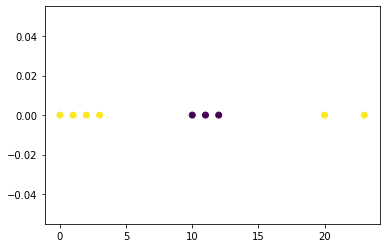

In [9]:
import matplotlib.pyplot as plt

data = np.array([0, 1, 2, 3, 10, 11, 12, 20, 23]).reshape(-1, 1)
label = np.array([1, 1, 1, 1, 0, 0, 0, 1, 1])

# This is not linear seperatable.
plt.scatter(data, [0]*len(data), c=label)
plt.show()

We could use polynomial kernel to do transformation, say:
$$\hat(y) = (a*b+ r)^n$$

Then if we set `r=1/2` and `n=2`, then we will get:
$$\hat(y) = (a* b + 1/ 2)^2$$
Then split it:
$$\hat(y) = (a*b+1/2) * (a*b+1/2)$$ <br> $$= (a*b)^2 + a*b + 1/4 $$ <br> $$  = a*b + (a*b)^2 + 1/4$$

Then convert with dot product:
$$\dot((a, a^2, 1/2), (b, b^2, 1/2))  = a*b + a^2 * b^2 + 1/4 $$

Then we could just compute original data into 3D, but for `1/2` could be ignored, then we could convert 1D into 2D with: $(X, X^2)$

22.00911251980982 -55.19413629160056


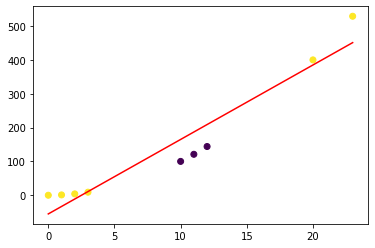

In [29]:
new_data = np.concatenate([data, data**2], axis=1)

# let's just create a linear line to seperate these data, 
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(new_data[:, 0].reshape(-1, 1), new_data[:, 1])

weights = lr.coef_[0]
bias = lr.intercept_
print(weights, bias)
# let's plot these data
plt.scatter(new_data[:, 0], new_data[:, 1], c=label)
plt.plot(new_data[:, 0], new_data[:, 0] * weights +bias, c='r')

So based on this plot that we could get idea that we could separate better than just 1D with convert into 2D.

But in fact we don't need to do real transformation, but with a poly function with `n=2` will get same output, that's called: `kernal trick`.